# Chapter11 Model Evaluation

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

## 11.1 Cross-Validation Models
Cross Validation is a supervised learning model, in order to overcome overfitting, we need to separate it into two parts. 

In k-fold cross validation(KFCV), we split data into $k$ parts called folds. The model then trained $k - 1$ folds, combined into one training set, and the last fold is used as a test set. Repeat $k$ times, using all $k$ folds as test set. The performance on the model for each of the $k$ iterations is then averaged to produce an overall measurement.

1. If the data is i.i.d, then it is a good idea to shuffle features and target(they are so called observations) when assigning to folds.

2. It is often benificial to have folds containing roughly the same percentage of observations from each of the different target class. Using `StratifiedKFold`.

3. Only train(`fit`) the training set and test(`transform`) both set.

In [2]:
digits = datasets.load_digits()
features = digits.data
target = digits.target
standardizer = StandardScaler()
logit = LogisticRegression()
# create a pipeline that standardize, then runs logistic regression
pipeline = make_pipeline(standardizer, logit)
# create k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=1)
# conduct k-fold cross-validation
cv_result = cross_val_score(pipeline,
                            features,
                            target,
                            cv=kf,
                            scoring="accuracy",
                            n_jobs=-1) # use all CPU scores
cv_result
cv_result.mean()

array([0.97777778, 0.98888889, 0.96111111, 0.94444444, 0.97777778,
       0.98333333, 0.95555556, 0.98882682, 0.97765363, 0.93854749])

0.9693916821849783

In [3]:
# create training and test set
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1
)
# fit for training set
standardizer.fit(features_train)
# transform both set
features_train_std = standardizer.transform(features_train)
features_test_std = standardizer.transform(features_test)

StandardScaler()

## 11.2 Creating a Baseline Regression Model
`DummyRegressor` is used as a baseline to compare against our model.

`mean` means that we use mean value as the model. Others are `median`, `constant`.

$$
R^2=1-\frac{\sum_i(y_i-\hat{y_i})^2}{\sum_i(y_i-\bar{y_i})^2}
$$

where $y_i$ is the true value of the target observation, $\hat{y_i}$ is the predicted value, and $\bar{y_i}$ is the mean value of for the target value.

The closer $R^2$ is to 1, the more of the variance in the target vector that is explained by the features. 

In [4]:
boston = datasets.load_boston()
features = boston.data
target = boston.target
print(features.shape)
print(target.shape)
# make split
features_train, features_test, target_train, target_test = train_test_split(
    features, target, random_state=0
)
# create a dummy regression
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train)
# get R-squared score
dummy.score(features_test, target_test)

(506, 13)
(506,)


DummyRegressor()

-0.001119359203955339

In [5]:
# compare wit linear regression model
ols = LinearRegression()
ols.fit(features_train, target_train)
ols.score(features_test, target_test)

LinearRegression()

0.6354638433202129

In [6]:
dummy = DummyRegressor(strategy='constant', constant=20)
dummy.fit(features_train, target_train)
dummy.score(features_test, target_test)

DummyRegressor(constant=array(20), strategy='constant')

-0.06510502029325727

## 11.3 Creating a Baseline Classification Model

In [7]:
iris = datasets.load_iris()
features = iris.data
target = iris.target
features_train, features_test, target_train, target_test = train_test_split(
    features, target, random_state=0
)
# create a dummy classifier
dummy = DummyClassifier(strategy='uniform', random_state=1)
dummy.fit(features_train, target_train)
dummy.score(features_test, target_test)

DummyClassifier(random_state=1, strategy='uniform')

0.42105263157894735

In [8]:
# compare with RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(features_train, target_train)
clf.score(features_test, target_test)

RandomForestClassifier()

0.9736842105263158

## 11.4 Evaluating Binary Classifier Predictions
TP is the number of true positives. Similar to TN, FP, FN.

$$
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
$$

In [9]:
x, y = datasets.make_classification(n_samples=10000,
                                    n_features=3,
                                    n_informative=3,
                                    n_redundant=0,
                                    n_classes=2,
                                    random_state=1)
print(x.shape)
print(y.shape)
logit = LogisticRegression()
cross_val_score(logit, x, y, scoring='accuracy')

(10000, 3)
(10000,)


array([0.9555, 0.95  , 0.9585, 0.9555, 0.956 ])

$$
Precision=\frac{TP}{TP+FP}
$$

In [10]:
cross_val_score(logit, x, y, scoring='precision')

array([0.95963673, 0.94820717, 0.9635996 , 0.96149949, 0.96060606])

$$
Recall=\frac{TP}{TP+FN}
$$

In [11]:
cross_val_score(logit, x, y, scoring='recall')

array([0.951, 0.952, 0.953, 0.949, 0.951])

$$
F_1=2\times\frac{Precision\times Recall}{Precision+Recall}
$$
It is a measure of correctness achieved in positive prediction, of observations labeled as positive, how many are actually positive.

In [12]:
cross_val_score(logit, x, y, scoring='f1')

array([0.95529884, 0.9500998 , 0.95827049, 0.95520886, 0.95577889])

If we have the true y adn the predicted y, we can calculate metrics like accuracy and recall directly

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
y_hat = logit.fit(x_train, y_train).predict(x_test)
accuracy_score(y_test, y_hat)
recall_score(y_test, y_hat)

0.947

0.9397590361445783

## 11.5 Evaluating Binary Classifier Thresholds
Receiving Operating Characteristic (ROC) curve compares the presence of TP and FP at every probability threshold.

(10000, 10)
(10000,)


LogisticRegression()

Text(0.5, 1.0, 'Received Operating Characteristic')

Text(0.5, 0, 'True Positive Rate')

Text(0, 0.5, 'False Positive Rate')

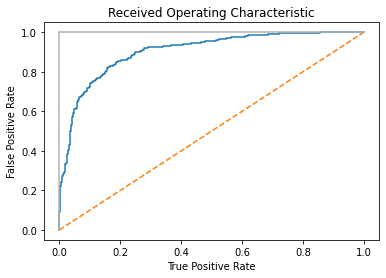

In [15]:
features, target = datasets.make_classification(n_samples=10000,
                                                n_features=10,
                                                n_informative=3,
                                                n_classes=2,
                                                random_state=3)
print(features.shape)
print(target.shape)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=0
)
logit = LogisticRegression()
logit.fit(features_train, target_train)
# get predicted probability
target_probability = logit.predict_proba(features_test)[:, 1]
# create TP and FP rates
fp, tp, threshold = roc_curve(target_test, target_probability)
# plot roc curve
plt.title("Received Operating Characteristic")
plt.plot(fp, tp)
plt.plot([0, 1], ls='--')
plt.plot([0, 0], [1, 0], c="0.7")
plt.plot([1, 1], c="0.7")
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.show()